In [1]:
import torch
from torchtext.data import Field,TabularDataset,LabelField,BucketIterator
import pandas as pd

#### Convert raw reviews data into dataframe, split to train and valid dataset then save to .csv

In [2]:
filename="reviews_labeled.txt"

#Convert text file into dataframe
file=open(filename,"r")
df=pd.DataFrame()
for line in file:
    text,label=line.split('|')
    df=df.append(pd.DataFrame({'review':text,'label':int(label)},index=[0]))

df=df.reset_index()
del df['index']

#Shuffle rows in dataframe
from sklearn.utils import shuffle
df = shuffle(df)
split_ratio=0.8
train,valid=df[:int(split_ratio*len(df))],df[int(split_ratio*len(df)):]
valid,test=valid[:int(len(valid)/2)],valid[int(len(valid)/2):]

#Check if negative/positive rows are distributed equally
print(train['label'].value_counts())
print(valid['label'].value_counts())

#Export to .csv
train.to_csv('train.csv',index=False)
valid.to_csv('valid.csv',index=False)
test.to_csv('test.csv',index=False)

1    4290
0    4239
Name: label, dtype: int64
0    543
1    523
Name: label, dtype: int64


In [3]:
print(f'Size of training set: {len(train)}')
print(f'Size of validation set: {len(valid)}')
print(f'Size of test set: {len(test)}')

Size of training set: 8529
Size of validation set: 1066
Size of test set: 1067


In [4]:
df.head(10) #Show how dataframe looks like

,review,label
3038,a lousy movie that s not merely unwatchable bu...,0
8049,the film is impressive for the sights and soun...,1
10490,bittersweet comedy drama full of life hand ges...,1
4209,often lingers just as long on the irrelevant a...,0
7202,ryan gosling is at 22 a powerful young actor,1
2643,i didn t believe for a moment in these villain...,0
6002,the film benefits greatly from a less manic to...,1
5069,ultimately sarah s dedication to finding her h...,0
10379,the rare imax movie that you ll wish was longe...,1
7329,the film delivers what it promises a look at t...,1


#### Load .csv into torch object 

In [5]:
TEXT=Field(tokenize='spacy',include_lengths = True)
LABEL =LabelField(dtype=torch.float)

datafield=[('review',TEXT),('label',LABEL)]
train,valid=TabularDataset.splits(path='',train='train.csv',validation='valid.csv',format='csv',skip_header=True,
                                  fields=datafield)
test=TabularDataset(path='test.csv',format='csv',fields=datafield)

print(f'Number of training examples: {len(train)}')
print(f'Number of testing examples: {len(valid)}')

Number of training examples: 8529
Number of testing examples: 1066


#### Build vocabolary and keep only the most 10000 frequent words

In [6]:
MAX_VOCAB_SIZE=25_000
TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE,
                 vectors='glove.6B.100d',
                 unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train)

In [7]:
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator,test_iterator = BucketIterator.splits(
    (train, valid,test), 
    batch_size =BATCH_SIZE,
    device = device,
    sort_key=lambda x:len(x.review),
    sort_within_batch=False,
    repeat=False)

#### Build RNN architecture

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))           
        return self.fc(hidden.squeeze(0))
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [9]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX=TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX]=torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX]=torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([16477, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842],
        [ 0.2512,  0.6499, -0.2465,  ...,  0.0659, -0.9114,  0.4129],
        [ 1.7732,  1.7099, -0.3068,  ..., -2.1893,  3.6804, -0.7701]])


#### Select optimizer and criterion

In [10]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

#### Train, Evaluate, Accuracy measurement function

In [11]:
def binary_accuracy(preds, y):
    rounded_preds =torch.round(torch.sigmoid(preds))
    correct=(rounded_preds == y).float() 
    acc=correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss=0
    epoch_acc=0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.review
        predictions = model(text,text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss=0
    epoch_acc=0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text,text_lengths=batch.review
            predictions=model(text,text_lengths).squeeze(1)
            loss=criterion(predictions, batch.label)
            acc=binary_accuracy(predictions, batch.label)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time
def epoch_time(start_time, end_time):
    elapsed_time=end_time-start_time
    elapsed_mins=int(elapsed_time/60)
    elapsed_secs=int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins,elapsed_secs

#### Train the model

In [12]:
N_EPOCHS = 5

best_valid_loss = float('inf')
valid_a=[]
train_a=[]
valid_l=[]
train_l=[]
for epoch in range(N_EPOCHS):

    start_time=time.time()
    
    train_loss,train_acc=train(model, train_iterator, optimizer, criterion)
    valid_loss,valid_acc=evaluate(model, valid_iterator, criterion)
    
    end_time=time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    valid_a.append(valid_acc)
    train_a.append(train_acc)
    valid_l.append(valid_loss)
    train_l.append(train_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 41s
	Train Loss: 0.614 | Train Acc: 66.05%
	 Val. Loss: 0.527 |  Val. Acc: 73.27%
Epoch: 02 | Epoch Time: 3m 56s
	Train Loss: 0.508 | Train Acc: 74.86%
	 Val. Loss: 0.485 |  Val. Acc: 76.23%
Epoch: 03 | Epoch Time: 3m 56s
	Train Loss: 0.424 | Train Acc: 80.42%
	 Val. Loss: 0.485 |  Val. Acc: 78.38%
Epoch: 04 | Epoch Time: 3m 54s
	Train Loss: 0.363 | Train Acc: 84.17%
	 Val. Loss: 0.474 |  Val. Acc: 77.15%
Epoch: 05 | Epoch Time: 3m 58s
	Train Loss: 0.313 | Train Acc: 86.41%
	 Val. Loss: 0.454 |  Val. Acc: 79.10%


#### Test Evaluation

In [13]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.408 | Test Acc: 81.92%


#### Visualize training and validation accuracy 

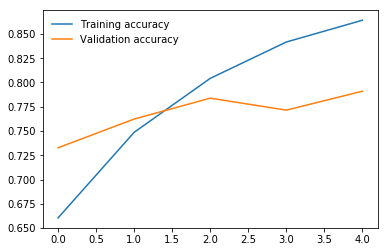

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_a, label='Training accuracy')
plt.plot(valid_a, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

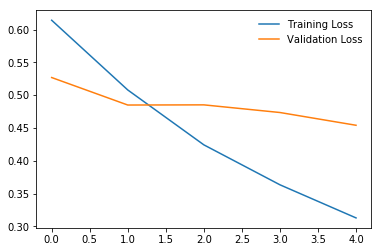

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_l, label='Training Loss')
plt.plot(valid_l, label='Validation Loss')
plt.legend(frameon=False)
plt.show()

#### Predict input sentence 

In [16]:
import spacy
nlp = spacy.load('en')
def predict(model_name,text):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(text)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    rounded_preds =torch.round(torch.sigmoid(model(tensor,length_tensor)))
    return ('Positive' if rounded_preds.item()<=0.5 else 'Negative')

In [17]:
predict('tut1-model.pt','it s a familiar story but one that is presented with great sympathy and intelligence')

'Positive'

In [18]:
predict('tut1-model.pt','unfortunately the story and the actors are served with a hack script')

'Negative'